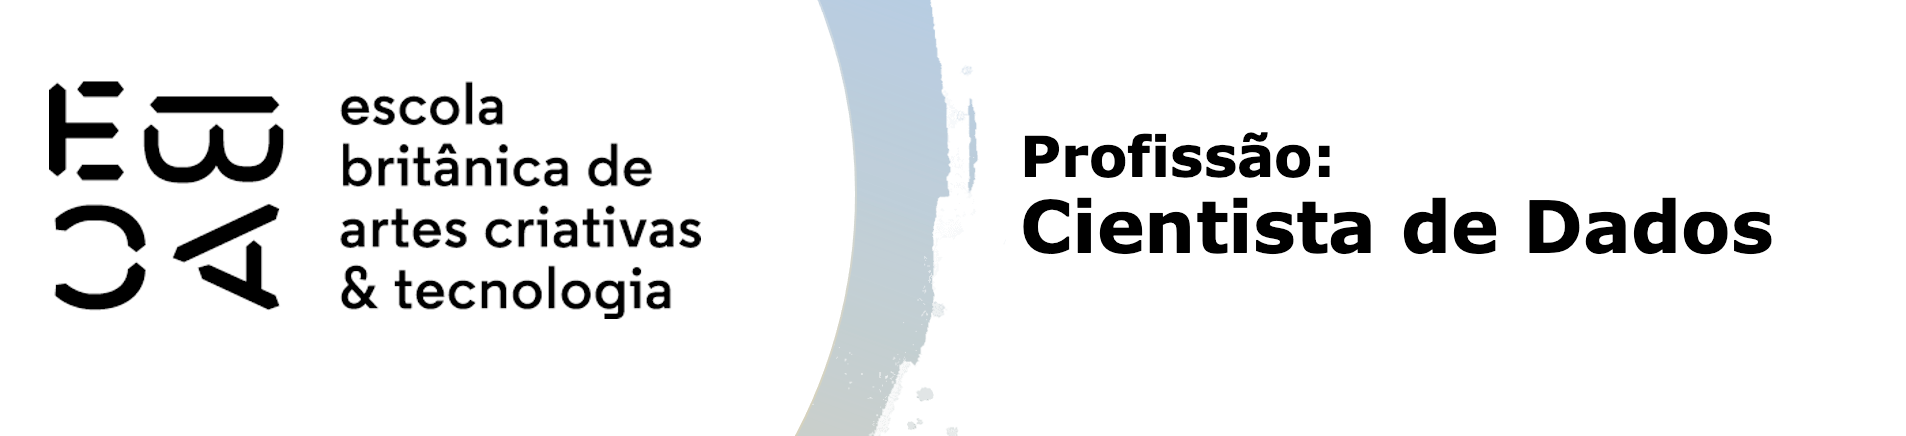

________

### Aluno: Victor Resende

________

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variáveis calculadas pelo google analytics

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score


In [107]:
df = pd.read_csv('online_shoppers_intention.csv')

In [108]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [109]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

#### Distribuição da variável
- Verificando o equilíbrio entre as classes de compradores e não compradores:

In [112]:
df['Revenue'].value_counts(dropna=False)


Revenue
False    10422
True      1908
Name: count, dtype: int64

#### Verificação de Valores Missing
- Identificando e lidando com possíveis valores ausentes nas variáveis do escopo:

In [114]:
# Verificando valores missing:
df.isnull().sum()


Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

#### Análise Descritiva das Variáveis Numéricas
- Explorando as variáveis numéricas para entender melhor suas distribuições. Uso de histogramas e boxplots.

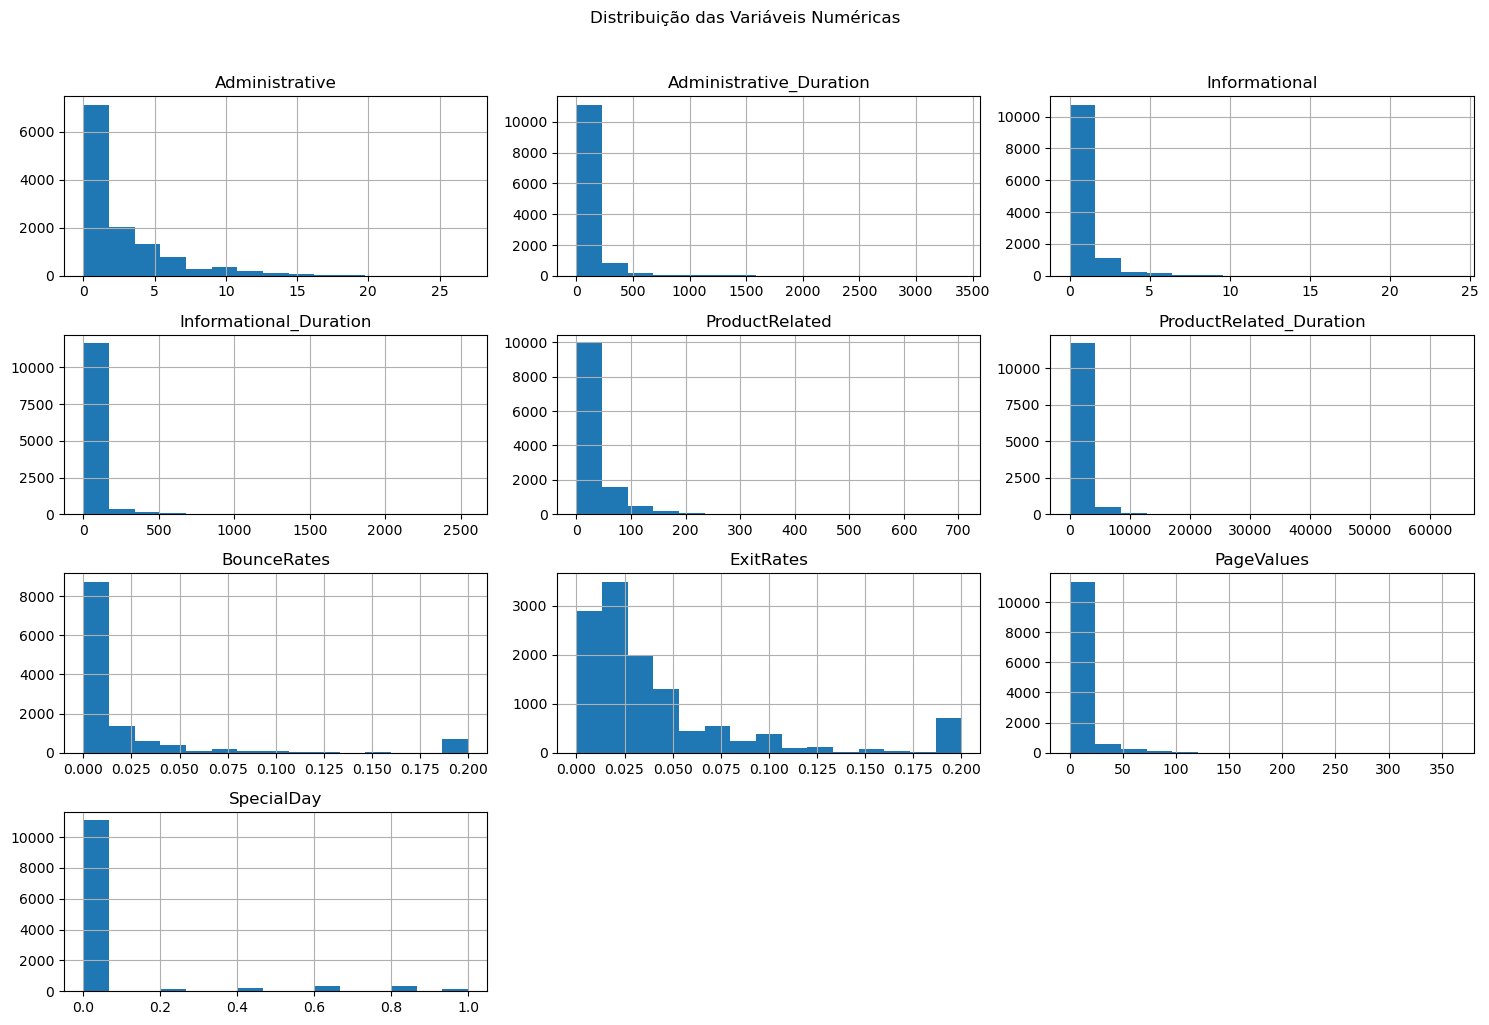

In [116]:
# Estatísticas descritivas:
df.describe()

# Distribuição das variáveis numéricas com histogramas:
numeric_vars = ['Administrative', 'Administrative_Duration', 'Informational', 
                'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
                'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

df[numeric_vars].hist(bins=15, figsize=(15, 10))
plt.suptitle('Distribuição das Variáveis Numéricas', y=1.02)
plt.tight_layout()
plt.show()


#### Tratamento de Variáveis Categóricas
- Variáveis categóricas como Month, VisitorType, Weekend, codificadas para serem incluídas nos modelos de clustering:

In [118]:
# Transformando variáveis categóricas em dummies:
df_encoded = pd.get_dummies(df, columns=['Month', 'VisitorType', 'Weekend'], drop_first=True)


#### Normalização das Variáveis Numéricas
- Para melhorar a eficiência dos algoritmos de clustering:

In [120]:
# Normalizando as variáveis numéricas:
scaler = StandardScaler()
df_encoded[numeric_vars] = scaler.fit_transform(df_encoded[numeric_vars])


#### Verificação Final dos Dados:

In [122]:
# Exibindo uma amostra dos dados processados:
df_encoded.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,False,False,False,False,False,False,False,False,True,False
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,False,False,False,False,False,False,False,False,True,False
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,False,False,False,False,False,False,False,False,True,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,False,False,False,False,False,False,False,False,True,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,False,False,False,False,False,False,False,False,True,True


## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

#### Verificação e Tratamento de Valores Faltantes:

In [125]:
# Verificando valores faltantes:
missing_values = df.isnull().sum()
print("Valores faltantes por coluna:\n", missing_values[missing_values > 0])

# Tratamento de valores faltantes:
# Preenchendo valores faltantes nas variáveis numéricas com a média:
num_vars = ['Administrative', 'Administrative_Duration', 'Informational', 
            'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
            'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
for col in num_vars:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)

# Para variáveis categóricas, caso tenha algum valor faltante, preenchendo com o valor mais frequente:
cat_vars = ['Month', 'Weekend']
for col in cat_vars:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)


Valores faltantes por coluna:
 Series([], dtype: int64)


#### Codificação de Variáveis ​​Categóricas:

In [127]:
# Transformando a variável 'Month' em dummies:
df_encoded = pd.get_dummies(df, columns=['Month'], drop_first=True)

# Confirmando que 'Weekend' está em formato booleano (se não, convertemos):
df_encoded['Weekend'] = df_encoded['Weekend'].astype(int)


#### Normalização das Variáveis ​​Numéricas:
- Padronizando as variáveis numéricas para garantir que todas as variáveis ​​de comportamento de navegação estejam em uma escala semelhante:

In [129]:
# Padronizando as variáveis numéricas selecionadas:
scaler = StandardScaler()
df_encoded[num_vars] = scaler.fit_transform(df_encoded[num_vars])


#### Verificação final dos Dados:

In [131]:
# Visualizando o DataFrame final:
df_encoded.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Revenue,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,False,False,True,False,False,False,False,False,False,False
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,False,False,True,False,False,False,False,False,False,False
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,False,False,True,False,False,False,False,False,False,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,False,False,True,False,False,False,False,False,False,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,False,False,True,False,False,False,False,False,False,False


## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

#### Agrupamento Hierárquico com 3 e 4 Grupos:
- Utilizando o algoritmo de aglomeração hierárquica para criar os agrupamentos e, em seguida, aplicação de divisão para gerar 3 e 4 clusters. Para isso, vamos utilizar uma técnica de Clustering Aglomerativo (AgglomerativeClustering), configurando o número de clusters conforme necessário:

#### Agrupamento com 3 grupos:

In [135]:
# Definindo o modelo de cluster com 3 grupos:
cluster_model_3 = AgglomerativeClustering(n_clusters=3, linkage='ward')
# Ajustando o modelo aos dados:
df_encoded['Cluster_3'] = cluster_model_3.fit_predict(df_encoded[num_vars])


#### Agrupamento com 4 grupos:

In [137]:
# Definindo o modelo de cluster com 4 grupos:
cluster_model_4 = AgglomerativeClustering(n_clusters=4, linkage='ward')
# Ajustando o modelo aos dados:
df_encoded['Cluster_4'] = cluster_model_4.fit_predict(df_encoded[num_vars])


#### Visulização dos Dados
- Verificando a quantidade de sessões em cada grupo:

In [139]:
# Contagem de observações em cada cluster para 3 e 4 grupos:
print("Distribuição nos Clusters (3 Grupos):")
print(df_encoded['Cluster_3'].value_counts())

print("\nDistribuição nos Clusters (4 Grupos):")
print(df_encoded['Cluster_4'].value_counts())


Distribuição nos Clusters (3 Grupos):
Cluster_3
0    9994
1    1570
2     766
Name: count, dtype: int64

Distribuição nos Clusters (4 Grupos):
Cluster_4
1    9214
0    1570
3     780
2     766
Name: count, dtype: int64


#### Dendrograma (apenas com amostra reduzida)
- Para visualizar o dendrograma, sem comprometer o desempenho, selecionamos uma amostra de aproximadamente 500 observações:

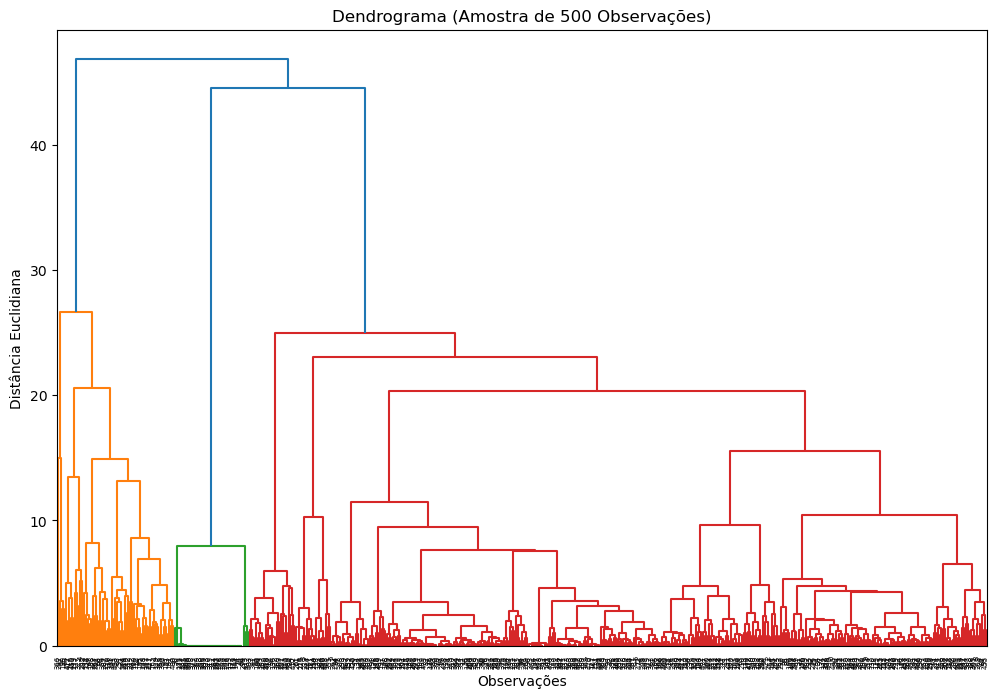

In [141]:
# Selecionando uma amostra de 500 registros:
sample_data = df_encoded[num_vars].sample(n=500, random_state=42)

# Gerando o dendrograma para a amostra:
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(sch.linkage(sample_data, method='ward'))
plt.title('Dendrograma (Amostra de 500 Observações)')
plt.xlabel('Observações')
plt.ylabel('Distância Euclidiana')
plt.show()


Observação: esse processo permite observar a estrutura hierárquica dos clusters com segurança e aplicar os agrupamentos diretamente nos dados completos sem problemas de desempenho. Após gerar os grupos, podemos analisar as características de cada cluster para entender melhor o perfil dos diferentes padrões de navegação e comportamento.

#### Dendrograma (apenas com amostra reduzida)
- Para visualizar o dendrograma, sem comprometer o desempenho, selecionamos uma amostra de aproximadamente 50 observações, para melhor visualização:

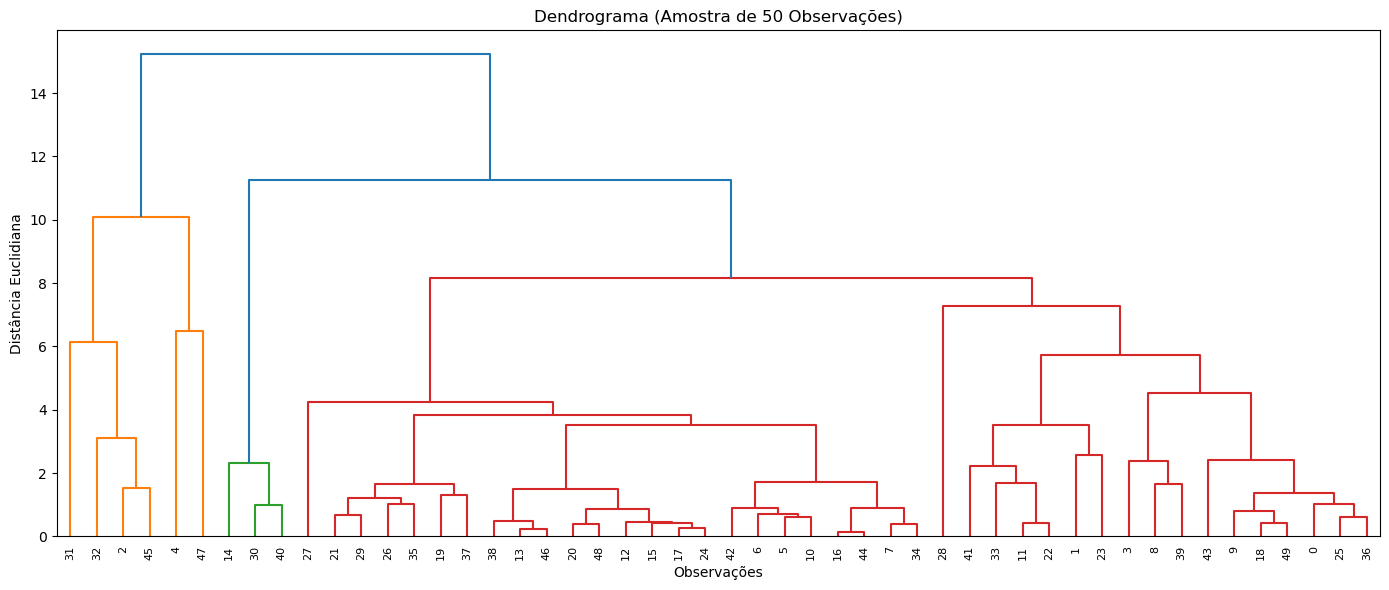

In [143]:
# Selecionar uma amostra de 50 registros para melhor visualização:
sample_data = df_encoded[num_vars].sample(n=50, random_state=42)

# Gerar o dendrograma com rótulos do eixo x rotacionados:
plt.figure(figsize=(14, 6))
dendrogram = sch.dendrogram(sch.linkage(sample_data, method='ward'))

# Rotacionar os rótulos do eixo x
plt.xticks(rotation=90)
plt.title('Dendrograma (Amostra de 50 Observações)')
plt.xlabel('Observações')
plt.ylabel('Distância Euclidiana')
plt.tight_layout()  # Ajustar o layout para evitar sobreposição
plt.show()


## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

#### Checagem e Tratamento de Valores Faltantes:

In [152]:
# Confirmar se o tratamento foi feito corretamente:
print(df.isnull().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


#### Agrupamento Hierárquico:
- Definindo dois modelos de agrupamento com diferentes números de clusters. Vamos usar 3 e 4 grupos para análise.

In [169]:
# Usando One-Hot Encoding para transformar colunas categóricas em variáveis numéricas:
df_encoded = pd.get_dummies(df_encoded, drop_first=True)


In [171]:
# Definindo o modelo de cluster com 3 grupos:
cluster_model_3 = AgglomerativeClustering(n_clusters=3, linkage='ward')
df['Cluster_3'] = cluster_model_3.fit_predict(df_encoded)

# Definindo o modelo de cluster com 4 grupos:
cluster_model_4 = AgglomerativeClustering(n_clusters=4, linkage='ward')
df['Cluster_4'] = cluster_model_4.fit_predict(df_encoded)


#### Análise Descritiva dos Grupos:

Análise Descritiva - 3 Grupos
           Administrative  Administrative_Duration  Informational  \
Cluster_3                                                           
0                2.083688                72.570076       0.417967   
1                2.372409                84.215946       0.543581   
2                2.324008                75.437651       0.427772   

           Informational_Duration  ProductRelated  ProductRelated_Duration  \
Cluster_3                                                                    
0                       23.137757       28.507801              1070.436230   
1                       39.772597       33.309977              1257.447458   
2                       24.427344       28.576297              1065.393785   

           BounceRates  ExitRates  PageValues  SpecialDay  
Cluster_3                                                  
0             0.028837   0.050060    5.958017    0.060709  
1             0.023705   0.044277    6.313499    0.06

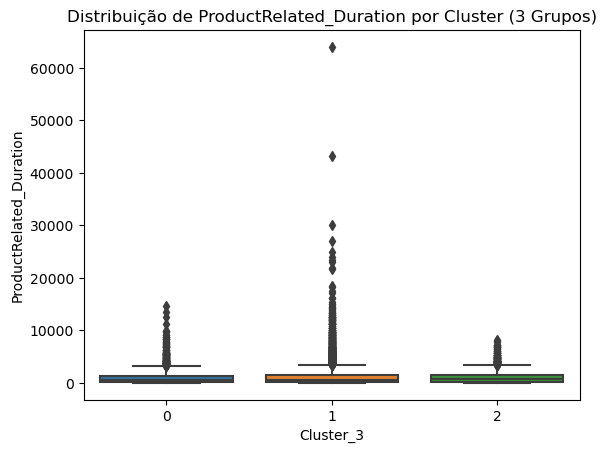


Análise Descritiva - 4 Grupos
           Administrative  Administrative_Duration  Informational  \
Cluster_4                                                           
0                2.372409                84.215946       0.543581   
1                2.104178                72.282030       0.432575   
2                2.324008                75.437651       0.427772   
3                1.910714                75.001748       0.294643   

           Informational_Duration  ProductRelated  ProductRelated_Duration  \
Cluster_4                                                                    
0                       39.772597       33.309977              1257.447458   
1                       24.024045       29.546801              1111.785382   
2                       24.427344       28.576297              1065.393785   
3                       15.655748       19.736607               721.368168   

           BounceRates  ExitRates  PageValues  SpecialDay  
Cluster_4                

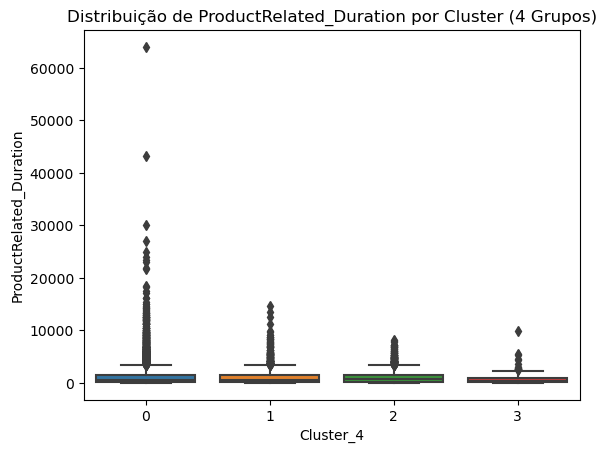

In [173]:
# Análise descritiva para o agrupamento com 3 grupos:
print("Análise Descritiva - 3 Grupos")
group_3_desc = df.groupby('Cluster_3')[numeric_vars].mean()
print(group_3_desc)

# Visualizando a distribuição das variáveis para 3 grupos:
sns.boxplot(x='Cluster_3', y='ProductRelated_Duration', data=df)
plt.title('Distribuição de ProductRelated_Duration por Cluster (3 Grupos)')
plt.show()

# Análise descritiva para o agrupamento com 4 grupos:
print("\nAnálise Descritiva - 4 Grupos")
group_4_desc = df.groupby('Cluster_4')[numeric_vars].mean()
print(group_4_desc)

# Visualizando a distribuição das variáveis para 4 grupos:
sns.boxplot(x='Cluster_4', y='ProductRelated_Duration', data=df)
plt.title('Distribuição de ProductRelated_Duration por Cluster (4 Grupos)')
plt.show()


#### Sugestão de nomes para os grupos:

- Cluster 0: "Visitantes Altamente Engajados" - Usuários que passam muito tempo em páginas de produtos.
- Cluster 1: "Visitantes de Navegação Rápida" - Usuários que acessam poucas páginas e rapidamente.
- Cluster 2: "Visitantes Ocasionalmente Interessados" - Usuários com engajamento moderado.

Para o agrupamento de 4 grupos:

- Cluster 0: "Novos Visitantes Engajados".
- Cluster 1: "Visitantes Recorrentes de Baixo Engajamento".
- Cluster 2: "Visitantes em Fim de Semana" - Usuários que acessam mais durante os fins de semana.
- Cluster 3: "Visitantes Informativos" - Focados em acessar páginas informativas.

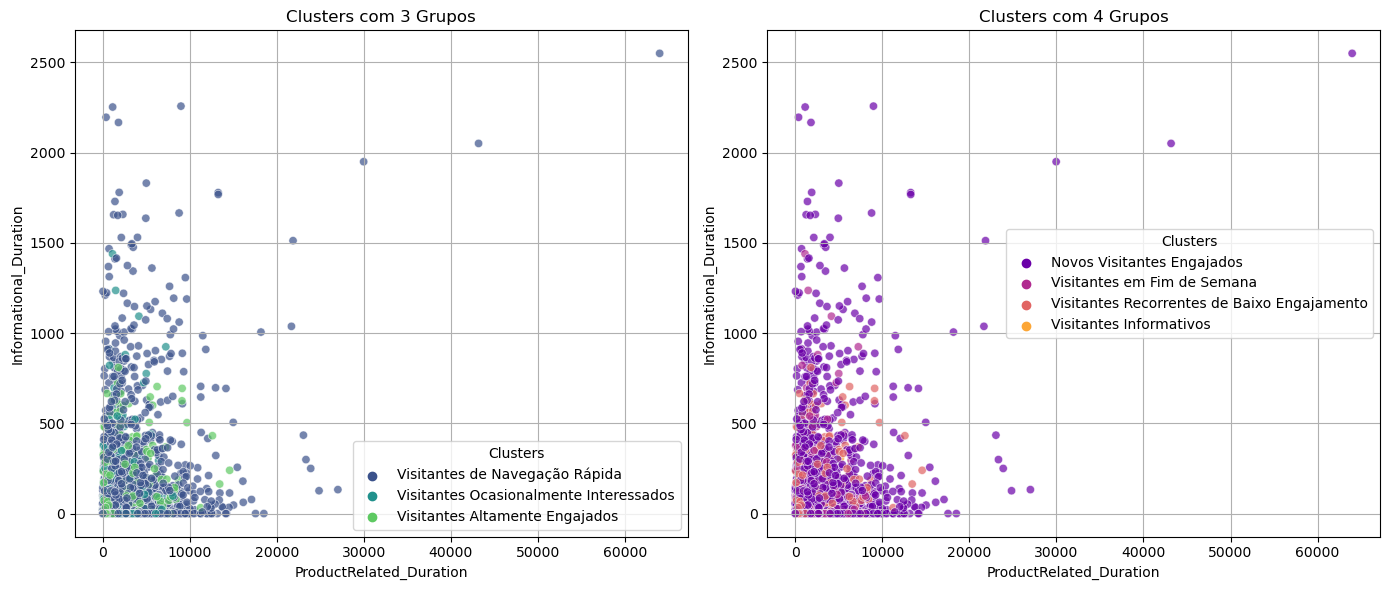

In [188]:
# Definindo as variáveis para os eixos:
feature_1 = 'ProductRelated_Duration'  # Tempo de acesso em páginas de produtos
feature_2 = 'Informational_Duration'    # Tempo de acesso em páginas informativas

# Gráficos para 3 clusters:
plt.figure(figsize=(14, 6))

# Gráfico para 3 clusters:
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x=feature_1, y=feature_2, hue='Cluster_3', palette='viridis', alpha=0.7)
plt.title('Clusters com 3 Grupos')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.legend(title='Clusters')
plt.grid(True)

# Gráfico para 4 clusters:
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x=feature_1, y=feature_2, hue='Cluster_4', palette='plasma', alpha=0.7)
plt.title('Clusters com 4 Grupos')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.legend(title='Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()


In [204]:
# Calculando o Silhouette Score para ambos os modelos:
silhouette_3 = silhouette_score(df_encoded, df['Cluster_3'])
silhouette_4 = silhouette_score(df_encoded, df['Cluster_4'])

print(f'Silhouette Score para 3 clusters: {silhouette_3}')
print(f'Silhouette Score para 4 clusters: {silhouette_4}')


Silhouette Score para 3 clusters: 0.24113043002157594
Silhouette Score para 4 clusters: 0.24465110840645335


#### Análise:

- Ambos os clusters apresentam grande potencial para compras dos clientes, visto os agrupamentos.

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

                                Cluster_3  BounceRates   Revenue
0          Visitantes Altamente Engajados     0.028837  0.158865
1  Visitantes Ocasionalmente Interessados     0.008691  0.144964
2          Visitantes de Navegação Rápida     0.023705  0.156019


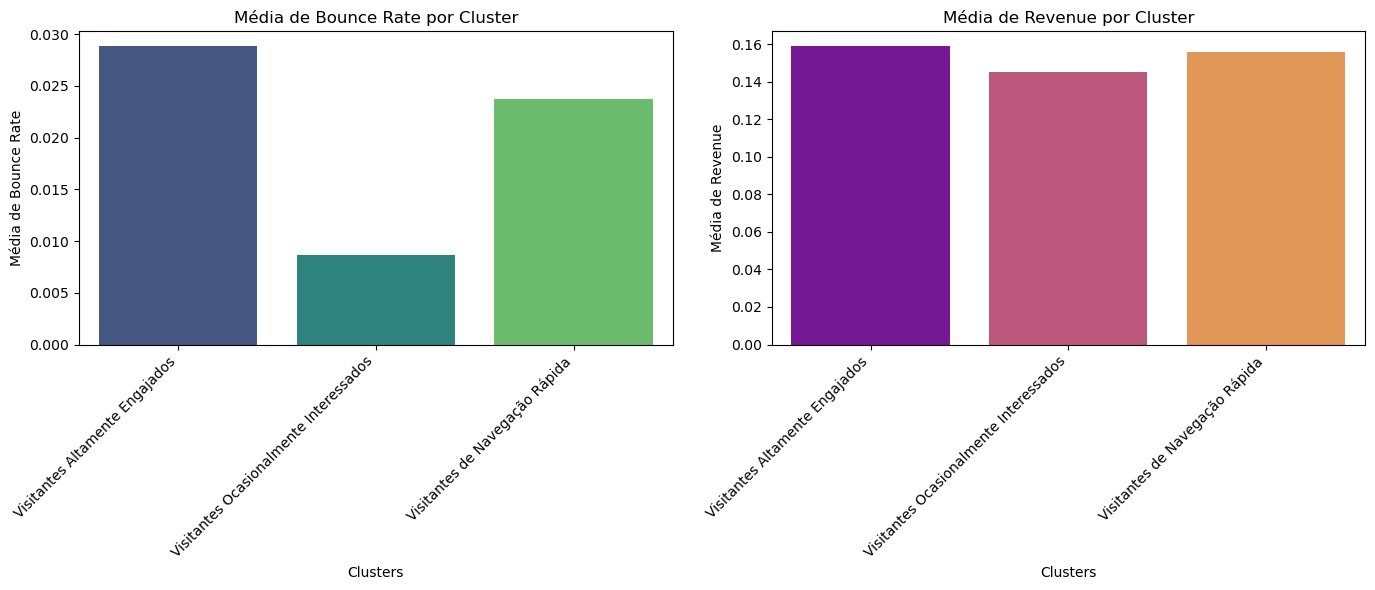

In [198]:
# Calculando médias de bounce rate e revenue por cluster:
cluster_stats = df.groupby('Cluster_3')[['BounceRates', 'Revenue']].mean().reset_index()

# Visualizando as médias:
print(cluster_stats)

# Criando gráficos de barras para comparação:
plt.figure(figsize=(14, 6))

# Gráfico de Bounce Rate:
plt.subplot(1, 2, 1)
sns.barplot(data=cluster_stats, x='Cluster_3', y='BounceRates', palette='viridis')
plt.title('Média de Bounce Rate por Cluster')
plt.xlabel('Clusters')
plt.ylabel('Média de Bounce Rate')
plt.xticks(rotation=45, ha='right')  # Rotaciona rótulos do eixo x para melhor visualização

# Gráfico de Revenue:
plt.subplot(1, 2, 2)
sns.barplot(data=cluster_stats, x='Cluster_3', y='Revenue', palette='plasma')
plt.title('Média de Revenue por Cluster')
plt.xlabel('Clusters')
plt.ylabel('Média de Revenue')
plt.xticks(rotation=45, ha='right')  # Rotaciona rótulos do eixo x para melhor visualização

plt.tight_layout()
plt.show()


### Análise:

- Os dois grupos possuem clientes propensos a compra, principalmente os visitanteas altamente engajados e de navegação rápida.
- Observamos, também, que visitantes ocasionalmente interessados podem ser grandes potenciais clientes para compra. Aqui cabe, então,  estratégias de copywriter (iscas digitais, estratégia de escassez de tempo etc.), por exemplo, para atrair esses clientes.

____